<a href="https://colab.research.google.com/github/Zelphire/Melanoma-Detection-Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize the project

Import basic libraries and confugure the directories

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

In [4]:
from tensorflow.keras.layers import Dropout

In [49]:
!ls

drive  sample_data


Setting up the data directory for train and test data. Data is currently being loaded from a google drive directory

In [ ]:
 data_dir_train = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Train")
 data_dir_test = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
##  path for testing in google drive commented for Assignment submission
## data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
## data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Looking at the amount of data available

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

Setting up the inital batch size and image size

In [7]:

batch_size = 32
img_height = 180
img_width = 180

In [8]:
import tensorflow as tf

In [9]:
help(tf.keras.preprocessing.image_dataset_from_directory)

Help on function image_dataset_from_directory in module keras.src.utils.image_dataset:

image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)
    Generates a `tf.data.Dataset` from image files in a directory.
    
    If your directory structure is:
    
    ```
    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg
    ```
    
    Then calling `image_dataset_from_directory(main_directory,
    labels='inferred')` will return a `tf.data.Dataset` that yields batches of
    images from the subdirectories `class_a` and `class_b`, together with labels
    0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).
    
    Supported image formats: 

In [10]:

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='int',  color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width), shuffle=True, seed=123, validation_split=0.2, subset="training")
# Print class names (optional)
class_names = train_ds.class_names
print("Class names:", class_names)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 80% for training, 20% for validation
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32  # You can adjust the batch size as needed
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:

# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data

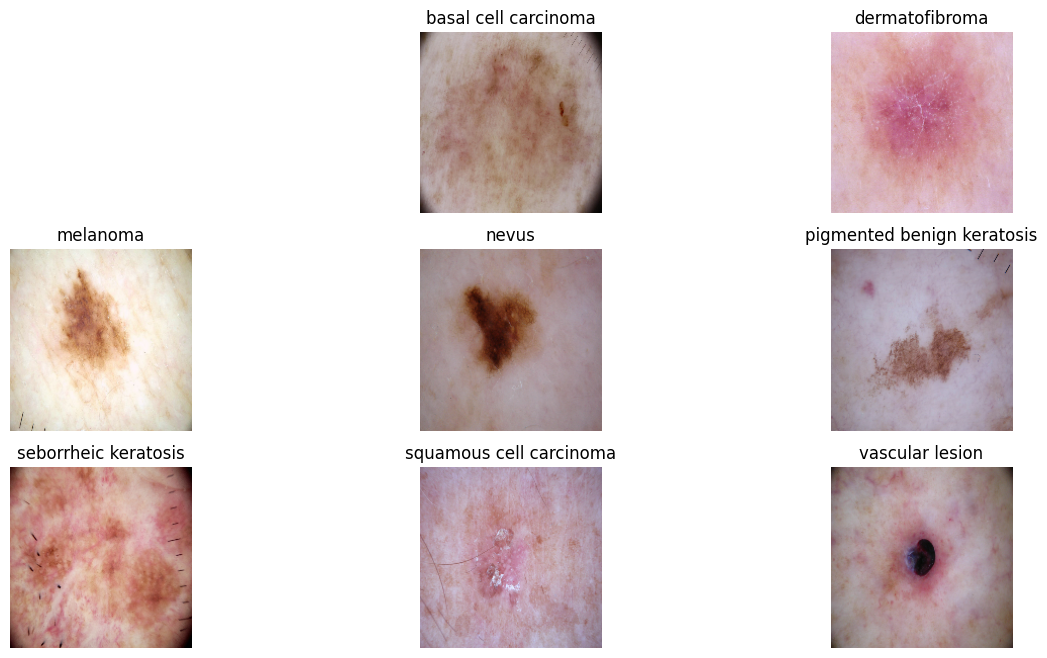

In [13]:
import matplotlib.pyplot as plt

# Get one batch of data from the validation dataset
for images, labels in val_ds.take(1):
    unique_labels = set(labels.numpy())

# Create a dictionary to store one instance for each class
one_instance_per_class = {}

# Iterate through the validation dataset to find one instance for each class
for images, labels in val_ds:
    for image, label in zip(images, labels):
        label = label.numpy()
        if label not in one_instance_per_class and label in unique_labels:
            one_instance_per_class[label] = image
            unique_labels.remove(label)

    if len(unique_labels) == 0:
        break
# Visualize one instance for each class
plt.figure(figsize=(15, 8))
for label, image in one_instance_per_class.items():
    class_name = class_names[label]
    plt.subplot(3, 3, label + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

In [14]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the Model

In [15]:
from tensorflow.keras import layers, models
# Define the input shape based on your image size
input_shape = (img_height, img_width, 3)

# Create the CNN model
model = models.Sequential()

# Rescale pixel values to the [0, 1] range
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))

In [16]:
# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


# Flatten layer to feed into densely connected layers
model.add(layers.Flatten())


# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# Output layer with softmax activation for 9 classes
model.add(layers.Dense(9, activation='softmax'))

In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if one-hot encoding labels
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 118336)            0

# Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 502s 3s/step - loss: 2.3298 - accuracy: 0.2026 - val_loss: 2.0646 - val_accuracy: 0.1834
Epoch 2/20
56/56 [==============================] - 105s 2s/step - loss: 1.9723 - accuracy: 0.2600 - val_loss: 1.9175 - val_accuracy: 0.2685
Epoch 3/20
56/56 [==============================] - 108s 2s/step - loss: 1.6443 - accuracy: 0.4051 - val_loss: 1.5757 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 108s 2s/step - loss: 1.4509 - accuracy: 0.4777 - val_loss: 1.4828 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 106s 2s/step - loss: 1.3316 - accuracy: 0.5140 - val_loss: 1.4124 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 119s 2s/step - loss: 1.2406 - accuracy: 0.5552 - val_loss: 1.4439 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 111s 2s/step - loss: 1.1313 - accuracy: 0.5898 - val_loss: 1.5669 - val_accuracy: 0.4922
Epoch 8/20
56

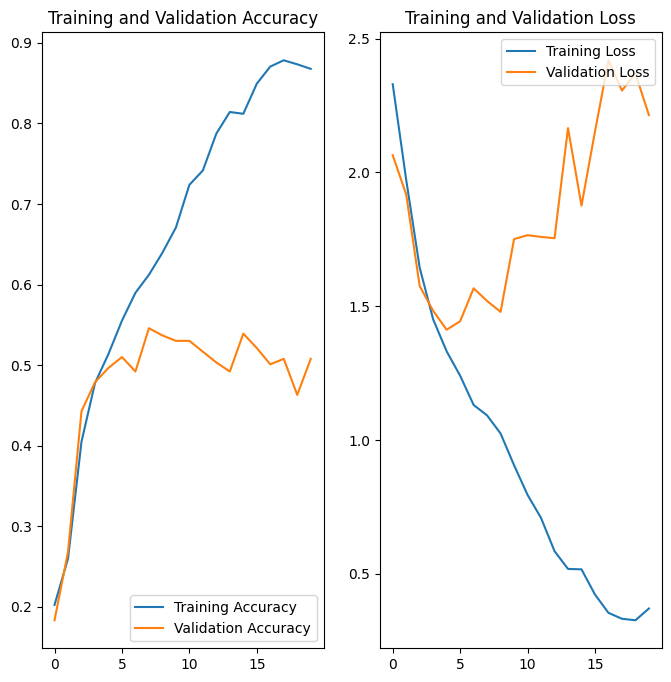

In [19]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above plot , we can see that raining accuracy continues to improve, but validation accuracy plateaus and Training loss decreases, but validation loss starts to increase significatly

The training accuracy of both models is higher than the validation accuracy, which suggests that the models are not generalizing well to new data.
The training loss of both models is lower than the validation loss, which is further evidence of overfitting.
The training accuracy and loss curves for both models plateau after a certain number of epochs, which suggests that the models have learned as much as they can from the training data and that further training is not likely to improve their performance.

This shows signs of model overfitting

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

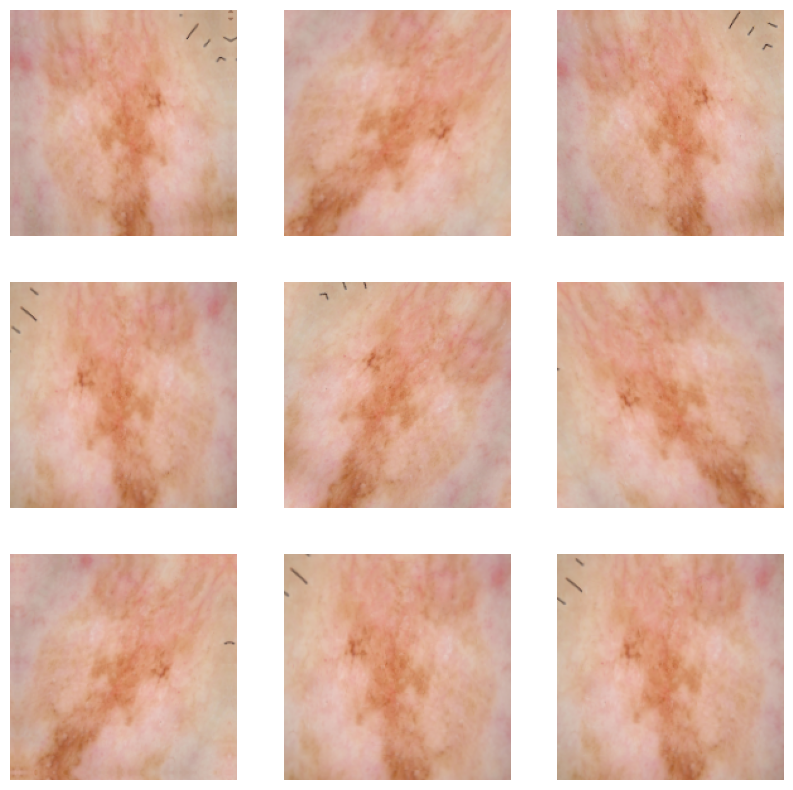

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 82s 1s/step - loss: 2.0800 - accuracy: 0.2076 - val_loss: 1.9187 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 75s 1s/step - loss: 1.8582 - accuracy: 0.3108 - val_loss: 1.8718 - val_accuracy: 0.2774
Epoch 3/20
56/56 [==============================] - 76s 1s/step - loss: 1.6881 - accuracy: 0.3778 - val_loss: 1.6140 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 74s 1s/step - loss: 1.4842 - accuracy: 0.4788 - val_loss: 1.5638 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 74s 1s/step - loss: 1.4010 - accuracy: 0.5078 - val_loss: 1.5582 - val_accuracy: 0.4474
Epoch 6/20
56/56 [==============================] - 79s 1s/step - loss: 1.3731 - accuracy: 0.5184 - val_loss: 1.3381 - val_accuracy: 0.5526
Epoch 7/20
56/56 [==============================] - 75s 1s/step - loss: 1.2815 - accuracy: 0.5402 - val_loss: 1.3364 - val_accuracy: 0.5481
Epoch 8/20
56/56 [==

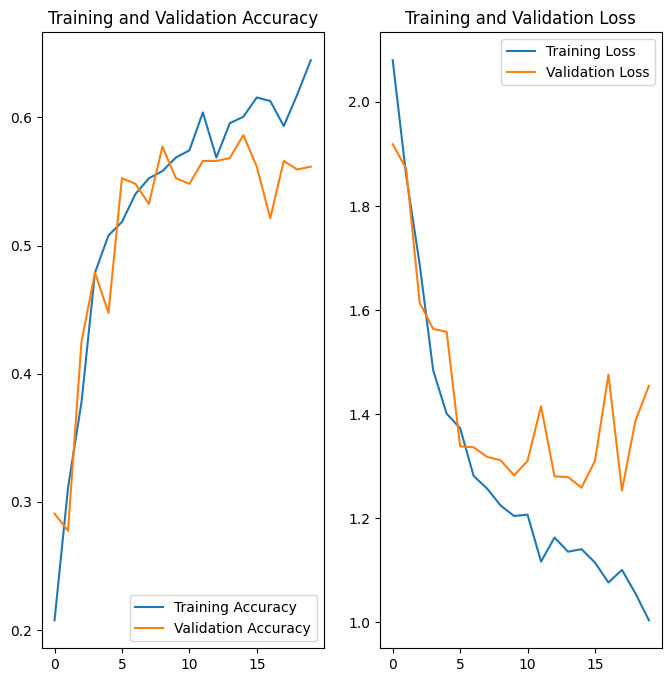

In [27]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

while the validation accuracy increases more slowly and plateaus after around 10 epochs. This suggests that the model is overfitting the training data, as the validation accuracy is not increasing as quickly as the training accuracy.

The training loss decreases steadily over time, while the validation loss decreases more slowly and plateaus after around 10 epochs. This is consistent with the observation that the model is overfitting the training data, as the validation loss is not decreasing as quickly as the training loss.

Current model shows great improvement to previous one

In [29]:
from glob import glob
import os
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [31]:
import pandas as pd
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Dataset...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Dataset...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Dataset...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Dataset...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Dataset...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Colab Notebooks/Dataset...,vascular lesion
2235,/content/drive/MyDrive/Colab Notebooks/Dataset...,vascular lesion
2236,/content/drive/MyDrive/Colab Notebooks/Dataset...,vascular lesion
2237,/content/drive/MyDrive/Colab Notebooks/Dataset...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


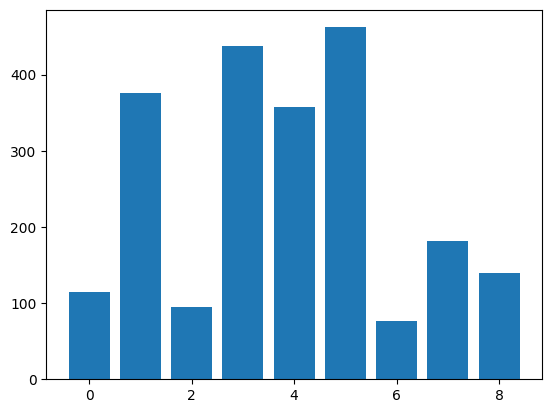

In [32]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Class 6 'seborrheic keratosis' is having the least number where as Class 5 ,'pigmented benign keratosis' , has the highest and more percentage
'pigmented benign keratosis'  accounts for 20.634% of the data and 'seborrheic keratosis' only accounts for 3.439% of the data

# Rectify Class Imbalance



In [33]:
!pip install Augmentor

In [35]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787F64BA8B50>: 100%|██████████| 500/500 [00:21<00:00, 23.30 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787F64B236D0>: 100%|██████████| 500/500 [00:20<00:00, 23.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x787F64C03A30>: 100%|██████████| 500/500 [00:22<00:00, 21.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x787F64AD4340>: 100%|██████████| 500/500 [01:46<00:00,  4.70 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787F641D6290>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787F64BA8B20>: 100%|██████████| 500/500 [00:22<00:00, 22.34 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x787F641B8310>: 100%|██████████| 500/500 [00:45<00:00, 11.07 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x787F641C63B0>: 100%|██████████| 500/500 [00:23<00:00, 21.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787F64BA8D30>: 100%|██████████| 500/500 [00:22<00:00, 21.78 Samples/s]


In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [37]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_7b960178-3d2e-4000-92e7-7cf4e7140740.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_12d8fd20-be5e-4b01-a44a-63053a7ad0da.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_f613d0ec-c9a2-4e2e-938e-e9235aa7735f.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_24a6c1c2-3f8a-4660-96cd-a0e52bd21928.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/Skin cancer ISIC The Internati

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [39]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-40-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [41]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

# Training with Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 219s 1s/step - loss: 2.0200 - accuracy: 0.2860 - val_loss: 1.5081 - val_accuracy: 0.4365
Epoch 2/20
169/169 [==============================] - 165s 975ms/step - loss: 1.4082 - accuracy: 0.4761 - val_loss: 1.4417 - val_accuracy: 0.4053
Epoch 3/20
169/169 [==============================] - 171s 1s/step - loss: 1.2156 - accuracy: 0.5601 - val_loss: 1.2280 - val_accuracy: 0.5405
Epoch 4/20
169/169 [==============================] - 178s 1s/step - loss: 1.0131 - accuracy: 0.6361 - val_loss: 1.0053 - val_accuracy: 0.6377
Epoch 5/20
169/169 [==============================] - 170s 1s/step - loss: 0.8113 - accuracy: 0.7133 - val_loss: 0.9029 - val_accuracy: 0.6793
Epoch 6/20
169/169 [==============================] - 165s 978ms/step - loss: 0.6625 - accuracy: 0.7756 - val_loss: 0.8640 - val_accuracy: 0.7112
Epoch 7/20
169/169 [==============================] - 167s 989ms/step - loss: 0.5421 - accuracy: 0.8175 - val_loss: 0.8160 - val_accurac

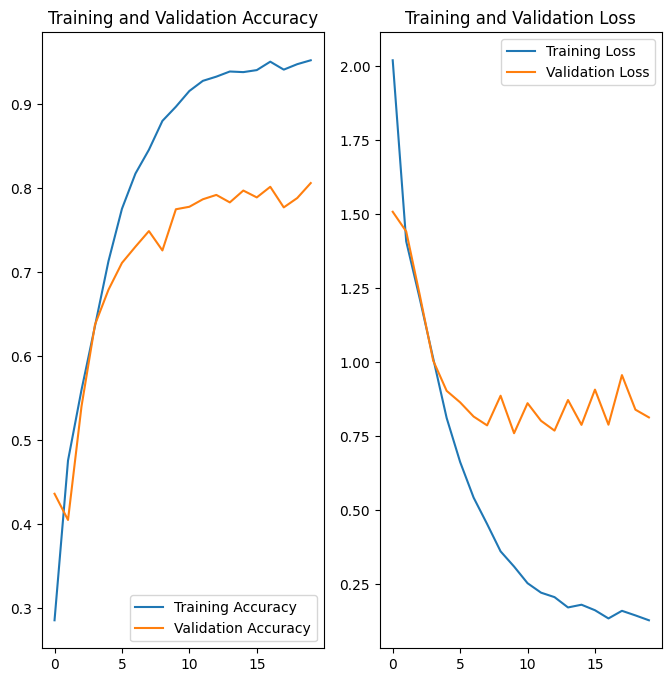

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The accuracy of both training and validation data increases over time, which is a good sign. However, the validation accuracy is slightly lower than the training accuracy, which suggests that the models may be overfitting the training data. For the second graph  the loss of both training and validation data decreases over time, which is also a good sign. However, the validation loss is slightly higher than the training loss, which further confirms that the models may be overfitting the training data.
 However from the previous models we can definately see a better improvement
